In [9]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("")

In [2]:
# Show all backends:
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [3]:
# Get IonQ's simulator backend:
simulator_backend = provider.get_backend("ionq_simulator")

In [4]:
import qiskit
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector

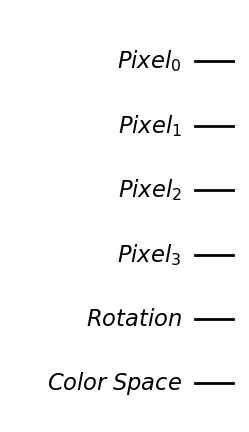

In [11]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister

pixel = QuantumRegister(size=4, name='Pixel')
rotation = QuantumRegister(size=1, name='Rotation')
color = QuantumRegister(size=1,name="Color Space")

qc = QuantumCircuit(pixel,rotation,color)
qc.draw('mpl')

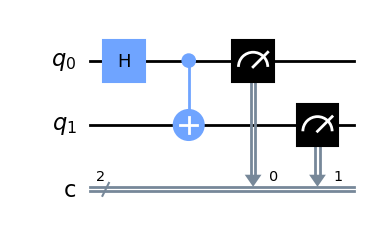

In [13]:
from qiskit import QuantumCircuit

# Create a basic Bell State.
qc = QuantumCircuit(2, 2) # 2 qubits, 2 bits
qc.h(0)
qc.cx(0, 1)

# Measure and put the result into the two bits.
qc.measure([0, 1], [0, 1])

# Display circuit.
qc.draw('mpl')

In [16]:
from qiskit.providers.jobstatus import JobStatus


# Run the circuit on IonQ's platform:
job = simulator_backend.run(qc, shots=10000) 

# Print the counts
print(job.get_counts())

{'00': 4930, '11': 5070}


In [17]:
# The simulator provides the ideal probabilities from the circuit, and the provider
# creates “counts” by randomly sampling from these probabilities. The raw (“true”)
# probabilities are also accessible by calling get_probabilities():
print(job.get_probabilities())

{'00': 0.5, '11': 0.5}


In [18]:
qpu_backend = provider.get_backend("ionq_qpu.harmony")
qpu_job = qpu_backend.run(qc) # if you don’t pass a shots kwarg, it defaults to 1024

In [19]:
from qiskit.providers.jobstatus import JobStatus
import time
# Check if job is done
while qpu_job.status() is not JobStatus.DONE:
	print("Job status is", qpu_job.status() )
	time.sleep(60)

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", qpu_job.status() )
print(qpu_job.get_counts()) # these counts are the “true” counts from the actual QPU Run

Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job stat

KeyboardInterrupt: 

In [ ]:
# for ease of use, the output probabilities (counts/shots) are still available:
print(qpu_job.get_probabilities())

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math


#from ibm_washington_config import coupling_map, basis_gates
#from ionq_config import coupling_map, basis_gates

In [2]:
from qiskit_aer.aerprovider import AerProvider


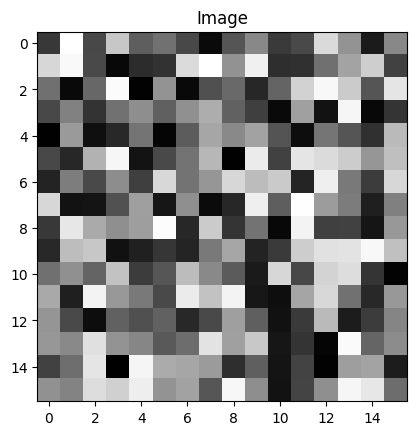

In [11]:
image = np.random.uniform(low=0, high=255, size=(16,16)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [12]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [13]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\HCI\AppData\Local\Temp\ipykernel_1892\2498201748.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [14]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 2274, # of qubits is 9


In [15]:
wash_qc = transpile(circuits=qc_image)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 2047


In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)

result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

C:\Users\HCI\AppData\Local\Temp\ipykernel_1892\4293248132.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


[154, 45, 49, 0, 189, 72, 40, 133, 35, 28, 196, 27, 191, 18, 33, 256, 44, 0, 135, 179, 256, 0, 235, 152, 256, 61, 0, 144, 256, 214, 0, 173, 78, 102, 55, 94, 215, 41, 130, 227, 58, 112, 0, 57, 126, 162, 84, 58, 156, 192, 41, 68, 256, 235, 185, 164, 49, 61, 58, 130, 256, 139, 135, 131, 96, 115, 161, 209, 141, 87, 102, 149, 238, 82, 69, 138, 224, 131, 124, 237, 31, 48, 124, 38, 78, 180, 223, 256, 68, 236, 56, 190, 238, 179, 210, 72, 256, 222, 190, 256, 42, 221, 256, 72, 147, 228, 0, 0, 0, 198, 35, 138, 23, 19, 129, 17, 111, 66, 124, 0, 97, 155, 117, 224, 196, 210, 103, 85, 36, 32, 48, 95, 137, 207, 27, 0, 229, 132, 150, 179, 238, 74, 229, 256, 32, 107, 227, 137, 238, 166, 210, 71, 83, 123, 110, 216, 165, 148, 238, 51, 169, 151, 173, 98, 147, 210, 0, 49, 215, 149, 0, 167, 123, 154, 85, 194, 24, 44, 32, 0, 230, 141, 200, 165, 0, 165, 162, 0, 114, 109, 236, 86, 256, 106, 160, 122, 118, 256, 164, 72, 129, 0, 28, 0, 127, 256, 256, 19, 110, 131, 101, 103, 173, 183, 204, 144, 202, 187, 94, 82, 2

In [9]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

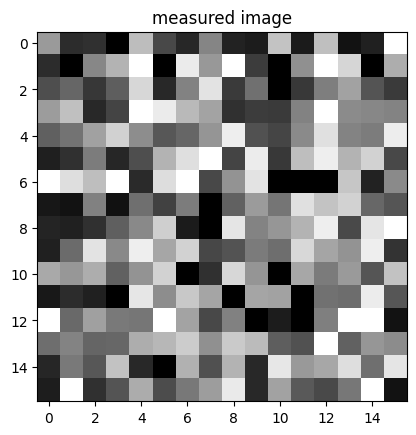

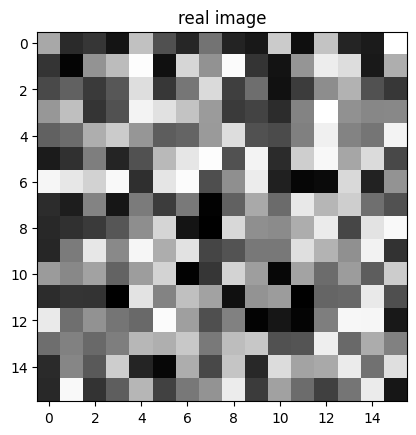

In [10]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [16]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("5sdYzS0yK6hBBLUu1pCCrYVgzw2txLiw")

In [19]:
simulator_backend = provider.get_backend("ionq_qpu.harmony")

In [20]:
simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
qobj = assemble(t_qc_image, shots=20000)
job = simulator_backend.run(qobj) 

result_oqim = job.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

AttributeError: 'QasmQobj' object has no attribute 'data'